In [1]:
%run ../robustness_analysis.ipynb

In [2]:
from lunarlander import LunarLander, INITIAL_RANDOM

In [3]:
# define variables and their bounds
wind_power = [0.0, 20.0]
turbulence_power = [0.0, 2.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([wind_power, turbulence_power])

# define the range of initial force apply to the lander
x0_bounds = np.repeat([[-INITIAL_RANDOM, INITIAL_RANDOM]], 2, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([5.0, 0.5])

In [4]:
def env_builder(delta):
    return LunarLander(enable_wind=True, continuous=True, wind_power=delta[0], turbulence_power=delta[1]), x0_bounds

In [5]:
from scipy import linalg

def lqr(s):
    # gravity = 9.8/FPS/FPS/SCALE
    gravity = 9.8 / FPS / FPS # gravity changes depending on SCALE
    m_main_inv = gravity / 0.56    # determined by test
    m_side_inv = gravity * 0.365    # determined by test
    a_sina_i_inv= 0.198 / 100 # determined by test # not depending on SCALE
    cos_alpha = 0.72

    # target point set
    x_target = 0
    y_target = 0   # the landing point is 0
    Vx_target = 0
    Vy_target = 0
    theta_target = 0
    omega_target = 0

    """
    Design of the reference trajectory
    """
    y_target = s[1] * (VIEWPORT_H / SCALE / 2) / 1.6 # 1.6 succeeds all the times

    """
    Design of a state space representation
    """
    X = np.array([
        [s[0] * (VIEWPORT_W / SCALE / 2) - x_target],
        [s[1] * (VIEWPORT_H / SCALE / 2) - y_target],
        [s[2] / (VIEWPORT_W / SCALE / 2) - Vx_target],
        [s[3] / (VIEWPORT_H / SCALE / 2) - Vy_target],
        [s[4] - theta_target],
        [s[5] / 20.0 - omega_target]
    ])

    A = np.array([
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, -1 * gravity, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0]
    ])

    B = np.array([
        [0, 0],
        [0, 0],
        [0, m_side_inv * cos_alpha * cos_alpha],
        [1 * m_main_inv, 0],
        [0, 0],
        [0, -1 * a_sina_i_inv]
    ])
    # the second term of the 4th row of B was igonred for simplification assuming that Fside is smaller than Fmain and negligible while Fmain is used

    sigma = np.array([
        [0],
        [0],
        [0],
        [-1 * gravity],
        [0],
        [0]
    ])

    # gravity compensation
    BTB = np.dot(B.T, B)
    u_sigma = -1 * np.linalg.inv(BTB).dot(B.T).dot(sigma)

    """
    Design of LQR
    Solve Riccati equation to find a optimal control input
    """
    R = np.array([
        [1, 0],
        [0, 1]
    ])

    Q = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 100, 0],
        [0, 0, 0, 0, 0, 100]
    ])

    # Solving Riccati equation
    P = linalg.solve_continuous_are(A, B, Q, R)
    # print("P {}\n".format(P))

    # u = -KX
    # K = R-1*Rt*P
    K = np.linalg.inv(R).dot(B.T).dot(P)
    # print("K {}\n".format(K))
    thrust = -1 * np.dot(K, X) + u_sigma
    # thrust = -1*np.dot(K, X)

    """
    Free fall from the final short distance
    """
    if s[1] < 0.3 / SCALE:
        thrust[0] = 0
        thrust[1] = 0

    # conversion to compensate main thruster's tricky thrusting
    thrust[0] = thrust[0] / 0.5 - 1.0

    a = np.array([thrust[0], thrust[1]])
    a = np.clip(a, -1, +1)  #  if the value is less than 0.5, it's ignored
    return a.flatten()

In [6]:
agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: lqr(obs),

    # some agents (like PID) needs to be reset for each run
    'model_reset': None
}

In [7]:
obs_space = env_builder(delta_0)[0].observation_space
angle_range = np.asarray([obs_space.low[4], obs_space.high[4]])
x_range = np.asarray([obs_space.low[0], obs_space.high[0]])
y_range = np.asarray([obs_space.low[1], obs_space.high[1]])


def stl_prop():    
    # G ( |angle| < 45 && |x| < 0.6|y| + 0.1 )
    angle = stl.Predicate('angle')
    delta_x = stl.Predicate('delta_x')
    
    angle_threshold = normalize(45 * 2 * np.pi / 360, angle_range)
    
    return stl.Always( (angle < angle_threshold) & (delta_x < 0.1) )
    

def signal_builder(records, time_index):    
    return {
        'angle': stl.Signal(
            normalize(np.abs(records[:, 4]), angle_range),
            time_index
        ),
        'delta_x': stl.Signal(
            normalize(np.abs(records[:, 0]), x_range) - normalize(np.abs(0.6 * records[:, 1]), y_range),
            time_index
        )
    }
    

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

In [8]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [9]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')
if not os.path.exists('data'):
    os.mkdir('data')

In [10]:
from datetime import datetime

In [11]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['steps_of_each_x0'] = 300
analysis.options['falsification_timeout'] = 1
analysis.options['falsification_num_trials'] = 2
analysis.options['deviation_timeout'] = 40
analysis.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 40,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 2,
 'falsification_episodes': 100,
 'falsification_num_processes': 0,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 300}

In [12]:
start = datetime.now()
delta, delta_dist = analysis.any_unsafe_deviation()


================ Any unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=240209, Tue Nov 22 09:27:14 2022)


KeyboardInterrupt: 

In [ ]:
print('Time to find any unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

In [ ]:
start = datetime.now()
delta, delta_dist = analysis.min_unsafe_deviation()

In [ ]:
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

In [ ]:
# analysis.visualize_deviation(delta, "gifs/min_counterexample.gif")

In [ ]:
ax, winds, turbulences, grid_data = analysis.grid_plot(wind_power, turbulence_power, 25, 25,
                                                       x_name="Wind", y_name="Turbulence",
                                                       z_name='STL Satisfaction')
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape.png', bbox_inches='tight')
plt.show()

In [ ]:
analysis.heatmap(wind_power, turbulence_power, 25, 25, x_name="Wind", y_name="Turbulence",
                 z_name='STL Satisfaction')
plt.savefig('gifs/robustness-landscape-heatmap.png', bbox_inches='tight')
plt.show()

In [ ]:
start = datetime.now()
boundary = analysis.robustness_boundary()

In [ ]:
print(boundary)
print('Time to approximate boundary:', datetime.now() - start)

In [ ]:
ax, winds, turbulences, grid_data = analysis.grid_plot(wind_power, turbulence_power, 25, 25,
                                                       x_name="Wind", y_name="Turbulence",
                                                       z_name='STL Satisfaction', boundary=boundary)
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape-boundary.png', bbox_inches='tight')
plt.show()

In [ ]:
analysis.heatmap(wind_power, turbulence_power, 25, 25, x_name="Wind", y_name="Turbulence",
                 z_name='STL Satisfaction', boundary=boundary)
plt.savefig('gifs/robustness-landscape-boundary-heatmap.png', bbox_inches='tight')
plt.show()

In [13]:
def episode_eval_reward(obs_record, reward_record):
    return reward_record.sum()

In [14]:
analysis_reward = RobustnessAnalysis(env_builder, agent, episode_eval_reward, delta_0, dev_bounds, dist)
analysis_reward.options['steps_of_each_x0'] = 300
analysis_reward.options['falsification_timeout'] = 1
analysis_reward.options['falsification_num_trials'] = 3
analysis_reward.options['deviation_timeout'] = 20
analysis_reward.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 20,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 3,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 300}

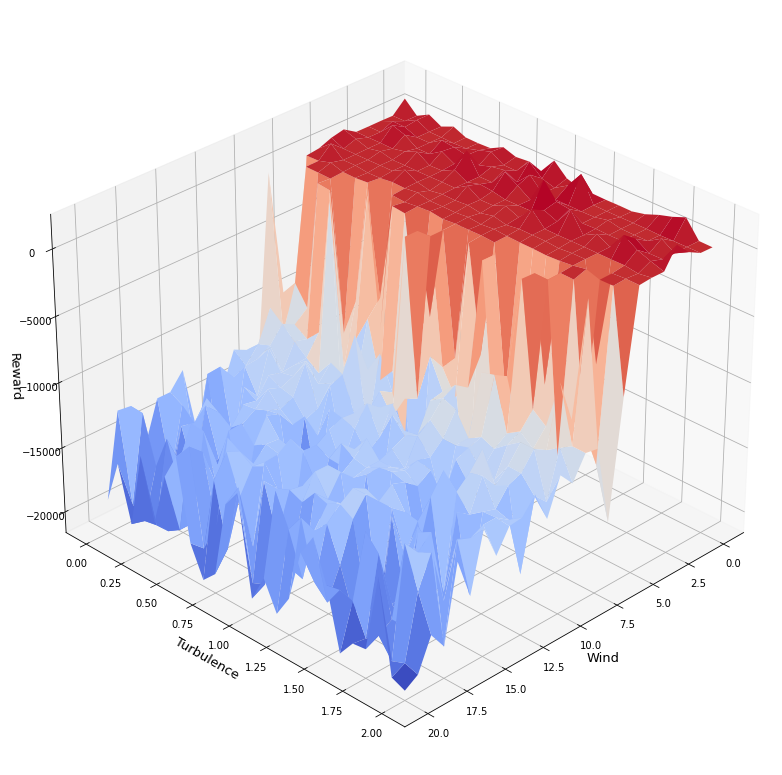

In [15]:
ax, winds, turbulences, grid_data = analysis_reward.grid_plot(wind_power, turbulence_power, 25, 25,
                                                              out_dir='data_reward',
                                                              x_name="Wind", y_name="Turbulence",
                                                              z_name='Reward')
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape-reward.png')
plt.show()